In [13]:
import pickle

import pyleoclim as pyleo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from matplotlib.ticker import FormatStrFormatter

In [14]:
with open('../data/preprocessed_series_dict.pkl','rb') as handle:
    preprocessed_series_dict = pickle.load(handle)

with open('../data/preprocessed_ens_dict.pkl','rb') as handle:
    preprocessed_ens_dict = pickle.load(handle)

with open('../data/pos_dict.pkl','rb') as handle:
    pos_dict = pickle.load(handle)

In [15]:
with open('../data/holo_chrons_study.pkl','rb') as handle:
    holo_chrons_study = pickle.load(handle)

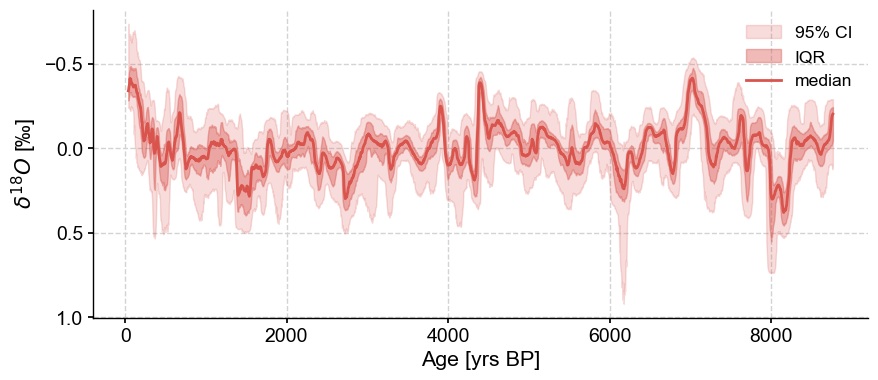

In [16]:
label = 'Dongge'
example_ens = preprocessed_ens_dict[label]

fig,ax=example_ens.common_time().plot_envelope()
ax.invert_yaxis()

In [17]:
sn = 1
i=0
record = holo_chrons_study[label]
#Load series
time = record['age']
value = record['d18O']
lat = pos_dict[label]['lat']
lon = pos_dict[label]['lon']
series = pyleo.GeoSeries(
    time = time,
    value=value,
    time_name = 'Age',
    time_unit = 'yrs BP',
    value_name = r'$\delta^{18} O$',
    value_unit = u'‰',
    label=label,
    lat = lat,
    lon=lon,
    archiveType='speleothem',
    verbose=False
).interp(time_axis=time).detrend()

#Slice the series to the Holocene
sliced = series.slice((0,10000))

#Fit AR1 model
g = pyleo.utils.ar1_fit(y=sliced.value,t=sliced.time)

#Generate surrogate values according to ar1 model
surr_value = pyleo.utils.tsmodel.ar1_model(t=series.time,tau=g)

#surr_value = pyleo.utils.tsmodel.ar1_sim(y=series.value,p= 1, t=series.time) 

#Load ensemble
chron = record['chron']
ens_list = []

for time_axis in chron:
    # Create surrogate series
    ens_series = pyleo.GeoSeries(
        time = time_axis,
        value = surr_value,
        time_name = 'Age',
        time_unit = 'yrs BP',
        value_name = r'$\delta^{18} O$',
        value_unit = u'‰',
        label=label,
        lat = lat,
        lon=lon,
        archiveType='speleothem',
        verbose=False
    )

    ens_list.append(ens_series)

ens = pyleo.EnsembleSeries(ens_list)


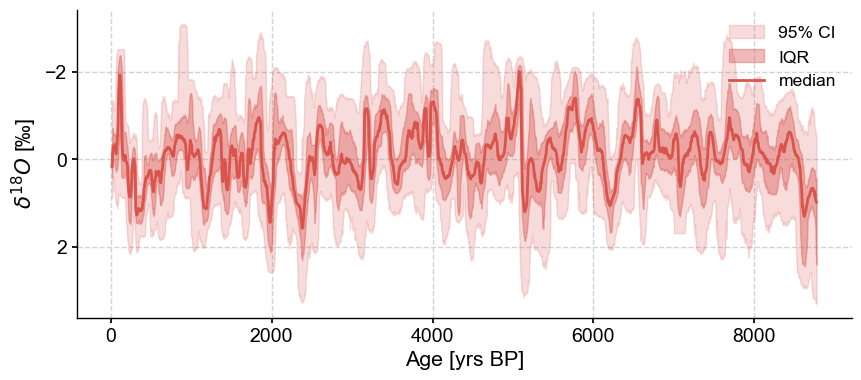

In [18]:
fig,ax=ens.common_time().plot_envelope()
ax.invert_yaxis()

In [19]:
# define the function of a spike
def spike(t,delta,A):
    ''' Function to create a spike
        t : float
            time
        A : float
            amplitude
        delta : float
            parameter for the curve'''
    f=1/(2*(len(t)-1))
    y = (A/np.arctan(1/delta))*np.arctan(np.sin(2*np.pi*t*f)/delta)
    return y

def add_spike(series,xstart,xend,A,method='smooth'):
    '''Function to add a spike to a pyleoclim series
    
    Parameters
    ----------

        series : pyleo.Series; 
            the series to which the spike will be added
        xstart : float
            the starting year of the spike
        xend : float
            the ending year of the spike
        A : float
            the amplitude of the spike
        method : str
            "smooth": add a spike by spike;
            otherwise, directly add values of A at each timestep'''
    x = series.time
    y  =series.value
    if method=='smooth':
        y[(x>=xstart)&(x<=xend)] += spike(np.arange(0,sum((x>=xstart)&(x<=xend))),0.02,A)
    else:
        y[(x>=xstart)&(x<=xend)] += [(x>=xstart)&(x<=xend)]+np.full(xend-xstart+1,A)

    spike_series = series.copy()
    spike_series.value = y
    return series

Time axis values sorted in ascending order


/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_20252/749308939.py:1: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True, which might modify your supplied time metadata.  Please set to False if you want a different behavior.
  line = pyleo.Series(time=series.time,value=np.zeros(len(series.time)))
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_20252/749308939.py:1: UserWarning: No time_unit parameter provided. Assuming years CE.
  line = pyleo.Series(time=series.time,value=np.zeros(len(series.time)))
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_20252/749308939.py:1: UserWarning: No time_name parameter provided. Assuming "Time".
  line = pyleo.Series(time=series.time,value=np.zeros(len(series.time)))


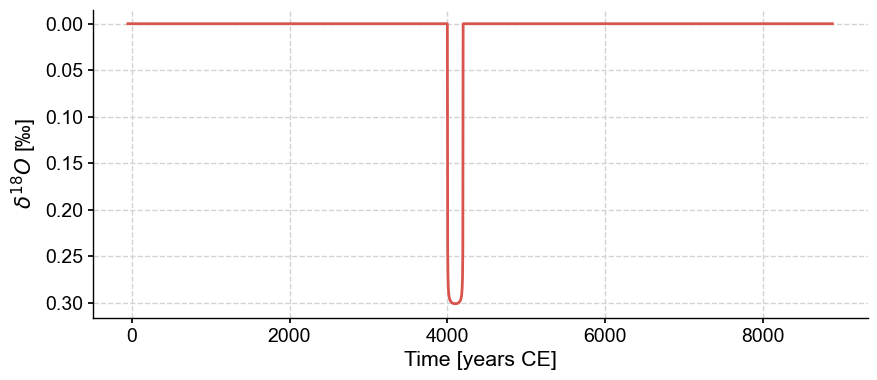

In [20]:
line = pyleo.Series(time=series.time,value=np.zeros(len(series.time)))
line_spike = add_spike(line,4000,4200,1.5*np.std(series.value))
line_spike.value_name = '$\delta^{18} O$'
line_spike.value_unit = '‰'
fig,ax=line_spike.plot(color=sns.xkcd_rgb['pale red'])
ax.invert_yaxis()

In [21]:
spike_ens = pyleo.EnsembleSeries([add_spike(series.copy(),4000,4200,2*np.std(series.value)) for series in ens.series_list])

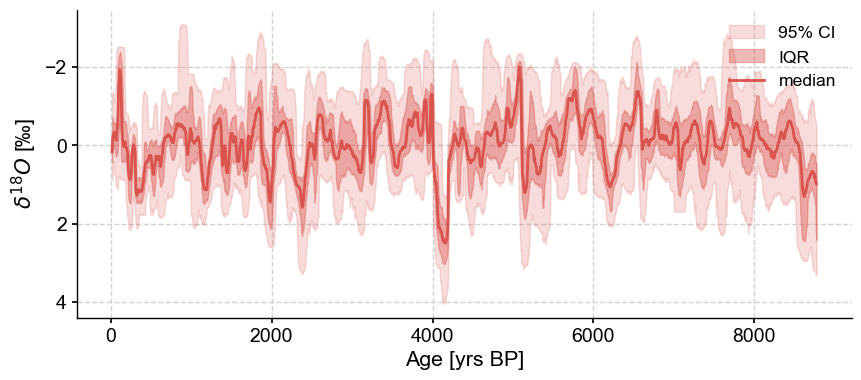

In [22]:
fig,ax=spike_ens.common_time().plot_envelope()
ax.invert_yaxis()

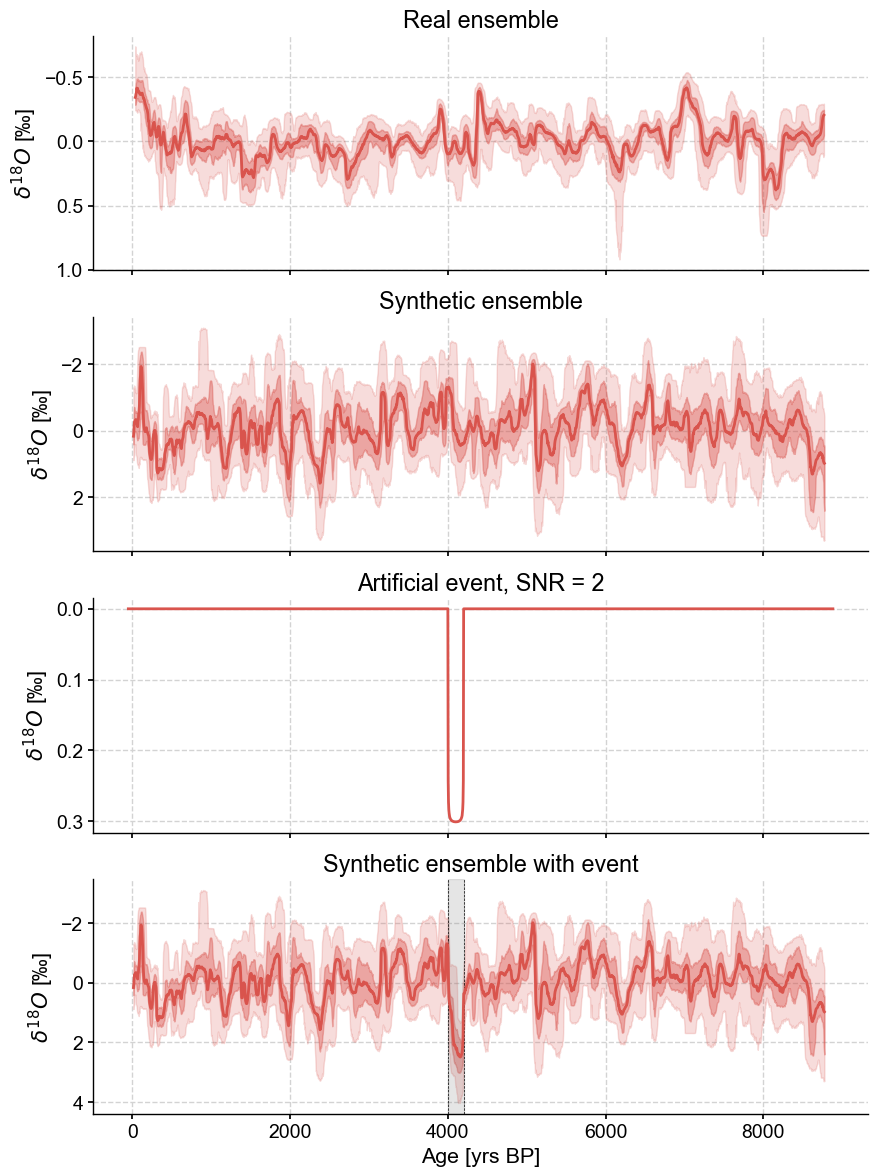

In [23]:
fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,14))
axes = ax.ravel()

example_ens.common_time().plot_envelope(ax=axes[0],title='Real ensemble')
ens.common_time().plot_envelope(ax=axes[1],title='Synthetic ensemble')
line_spike.plot(ax=axes[2],color=sns.xkcd_rgb['pale red'],title='Artificial event, SNR = 2')
spike_ens.common_time().plot_envelope(ax=axes[3],title='Synthetic ensemble with event')

for idx,axs in enumerate(axes):
    axs.invert_yaxis()
    axs.legend().set_visible(False)
    if idx < 3:
        axs.set_xlabel(None)
    else:
        axs.axvspan(4000,4200,color='grey',alpha=0.2)
        axs.axvline(4000,color='black',linestyle='--',linewidth=.5)
        axs.axvline(4200,color='black',linestyle='--',linewidth=.5)

In [24]:
pyleo.savefig(fig,'../figures/synthetic_ensemble_schematic.pdf')

Figure saved at: "../../figures/synthetic_ensemble_schematic.pdf"
